# **TEXT PREPROCESSING FUNCTION**

In [134]:
import pandas as pd
import re #regular expressions library for text manipulation
import string
import numpy as np
import unicodedata
import ast

from prettytable import PrettyTable

import csv
import os
import random

from glob import glob

#NLP libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy import displacy
from spacy.lang.en import English
import spacymoji
import emoji
import contractions

import itertools
from autocorrect import Speller

#for wordclouds
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

import matplotlib.pyplot as plt

In [50]:
#additional nlp models
#!python -m spacy download en_core_web_md

In [51]:
def clean_comments (filepath):
    #import data
    df = pd.read_csv(filepath, low_memory = False)
    
    #remove deleted comments if any
    df = df[df.Body != '[deleted]']
    df = df.dropna(subset=['Body'])
    
    #remove comments with missing id
    drop_index = df[df.isSubmitter.isnull()].index
    df.drop(drop_index, inplace = True)
    
    #remove duplicates if any
    df = df.drop_duplicates(subset =['ID'], ignore_index = True)
    df.reset_index (drop = True, inplace = True)
    
    #correct data types and column label
    df['Date_Created'] = pd.to_datetime(df['Date_Created'])
    df['year'] = df['Date_Created'].dt.year
    df['Score'] = df['Score'].astype('int') 
    df.rename(columns = {'Author_ID': "Author"}, inplace = True) 
    
    #rename 'Body' column to text
    df.rename(columns = {'Body': 'long_text',
                        'Date_Created': 'date_created'}, inplace = True)
    
    #remove unnecessary columns
    df.drop(columns = ['Unnamed: 0', 'Author', 'Score',
       'Parent_ID', 'Submission_ID', 'Subreddit', 'isParent', 'isSubmitter'], inplace = True)
    
    #remove any extra whitespace in column labels
    df.columns = df.columns.str.strip()
    
    #include column to denote row is comment entry
    df['text_type'] = 'comment'
    
    #rearrange column order
    df = df[['text_type','ID','date_created', 'year', 'long_text']]
    
    
        
    return df



In [52]:
def clean_submissions(filepath):
    df = pd.read_csv(filepath, low_memory = False)
    
    #drop duplicate posts
    df = df.drop_duplicates(subset =['ID'], ignore_index = True)
    df.reset_index (drop = True, inplace = True)
    
    #create column for post title + post text
    df['long_text'] = df['Title']+ " " +df['Post Text'].fillna('')
    
    #adjust data types
    df['Date Created'] = pd.to_datetime(df['Date Created'])
    df['year'] = df['year'].astype('int')
    
    #rename columns
    df.rename(columns = {'Date Created': 'date_created'}, inplace = True)
    
    #remove unwanted columns
    df = df.drop(columns = ['Unnamed: 0', 'Title','Post Text', 'Score',
       'Total Comments', 'Post URL', 'SubReddit','Unnamed: 0.1'])
    
    #include column to denote row is comment entry
    df['text_type'] = 'submission'
    
    #reorder columns - 'ID', 'Post Text'
    df  = df[['text_type','ID', 'date_created','year', 'long_text']]
    
    return df
    

In [53]:
#access dataset files
folder_path = os.path.join("..", "Data")
file_type = "*.csv"

#list of dataset file paths
document_path = glob(os.path.join(folder_path, file_type))

document_path

['../Data/corpus_v5.csv',
 '../Data/corpus_v4.csv',
 '../Data/filtered_corpus.csv',
 '../Data/corpus_v3.csv',
 '../Data/corpus_v2.csv',
 '../Data/full_posts.csv',
 '../Data/vocabulary.csv',
 '../Data/emoji_subset.csv',
 '../Data/sampled_subset.csv',
 '../Data/training_corpus.csv',
 '../Data/comments.csv',
 '../Data/corpus.csv']

In [54]:
comments_filepath = '../Data/comments.csv'
submissions_filepath = '../Data/full_posts.csv'


data = pd.concat([clean_comments(comments_filepath), clean_submissions(submissions_filepath)], ignore_index = True)

data

,text_type,ID,date_created,year,long_text
0,comment,gtfo2hl,2021-04-05 13:00:32,2021,"*Cuntry roads, take me hoem*"
1,comment,gtfqkbv,2021-04-05 13:41:40,2021,"That’s been there for several years, sent a pi..."
2,comment,gtfou07,2021-04-05 13:13:23,2021,I am single and I have not traveled to any cun...
3,comment,gtfrgpe,2021-04-05 13:56:09,2021,What happens when you shop at dragon mart...
4,comment,gtg5mwv,2021-04-05 16:51:54,2021,I am cunting on them to do so 😅
...,...,...,...,...,...
130047,submission,14f46ji,2023-06-21 14:40:54,2023,"Best beauty saloons in Dubai? Hello fellas, I ..."
130048,submission,14f4uyi,2023-06-21 15:15:27,2023,Found the r/dubai redditors who kept telling m...
130049,submission,14f4ri3,2023-06-21 15:10:25,2023,Scam ? Healthy.line My sister has a CBD debit ...
130050,submission,14f4k3r,2023-06-21 15:00:34,2023,Thoughts on Expo City properties? Anyone else ...


In [55]:
year_group = data.groupby(by='year')
for year, group in year_group:
    print (year,len(group))

2012 11
2013 60
2014 143
2015 206
2016 787
2017 1131
2018 1685
2019 4238
2020 29987
2021 28188
2022 36775
2023 26841


## **TEXT PREPROCESSING**

### **Convert all Text to Lowercase**

In [56]:
data['clean_text'] = data['long_text'].apply(lambda text: text.lower())

data.sample(n=5)

,text_type,ID,date_created,year,long_text,clean_text
98732,comment,jk8kvyk,2023-05-15 17:49:18,2023,People don't notice a lot goes unreported. \n\...,people don't notice a lot goes unreported. \n\...
29452,comment,iqzkbqi,2022-10-04 10:52:44,2022,Young family maybe. With infants.,young family maybe. with infants.
45148,comment,ge4pbgw,2020-11-30 11:57:32,2020,I prefer having a stock look with tweaks mainl...,i prefer having a stock look with tweaks mainl...
34489,comment,fq6qklo,2020-05-10 22:48:18,2020,Like your not wrong at all. All these people ‘...,like your not wrong at all. all these people ‘...
108882,comment,frdbeg6,2020-05-21 22:49:13,2020,Hang in there... Only good things will happen ...,hang in there... only good things will happen ...


## **Expand Word Contractions**

In [57]:
data['clean_text'] = data['clean_text'].apply(lambda text: contractions.fix(text)) 

data.sample(n=5)

,text_type,ID,date_created,year,long_text,clean_text
29359,comment,iqzpst7,2022-10-04 12:11:59,2022,Funny comments that talks about women taking c...,funny comments that talks about women taking c...
82647,comment,ierb4di,2022-07-04 03:46:46,2022,US is expensive? Lol. This guys has never live...,us is expensive? lol. this guys has never live...
82337,comment,izjgz4z,2022-12-09 19:45:56,2022,It has to be hard for you to be this cynical o...,it has to be hard for you to be this cynical o...
118785,comment,frqu94v,2020-05-25 10:27:48,2020,Great way to spend your time. Well done mate. 😁,great way to spend your time. well done mate. 😁
58035,comment,ho8hgx5,2021-12-12 15:20:35,2021,"Alright, then staying here and enjoying the pe...","alright, then staying here and enjoying the pe..."


## **Remove URLs**

In [58]:
#pd.reset_option('display.max_colwidth')

In [59]:
#index of rows with urls
html_index = data[data['long_text'].str.contains("https")].index
data.loc[html_index]

,text_type,ID,date_created,year,long_text,clean_text
17,comment,gtgyqzz,2021-04-05 20:49:12,2021,Meditation And Relaxation Music https://youtu....,meditation and relaxation music https://youtu....
83,comment,gpqwzwc,2021-03-05 10:34:53,2021,I am curious about this Apollo Fintech GSX coi...,i am curious about this apollo fintech gsx coi...
94,comment,gpqwrek,2021-03-05 10:31:45,2021,https://www.instagram.com/p/CKhzbwpH0c4/?igshi...,https://www.instagram.com/p/ckhzbwph0c4/?igshi...
174,comment,gq3tah4,2021-03-07 19:49:41,2021,"With all due respect, do you expect a law enfo...","with all due respect, do you expect a law enfo..."
293,comment,jb5kpz4,2023-03-06 20:35:11,2023,Here: Dubai Festival City\nhttps://maps.app.go...,here: dubai festival city\nhttps://maps.app.go...
...,...,...,...,...,...,...
129946,submission,14djkvs,2023-06-19 20:39:46,2023,Help‼️Uni qualification equivalency letter for...,help‼️uni qualification equivalency letter for...
130004,submission,14d2uk9,2023-06-19 07:06:28,2023,PSA: Villas are at high risk of fire during th...,psa: villas are at high risk of fire during th...
130006,submission,14d0c29,2023-06-19 05:00:13,2023,"Daily Random Discussion Thread Hello,\n\nThis ...","daily random discussion thread hello,\n\nthis ..."
130037,submission,14cieby,2023-06-18 15:43:08,2023,Need help with applying for residency - confus...,need help with applying for residency - confus...


In [60]:
#regex pattern for urls
url_pattern = r'https?://\S+'
#replace url with empty string
data['clean_text'] = data['clean_text'].apply(lambda text: re.sub(url_pattern, ' ', text, flags=re.MULTILINE))

data.loc[html_index]

,text_type,ID,date_created,year,long_text,clean_text
17,comment,gtgyqzz,2021-04-05 20:49:12,2021,Meditation And Relaxation Music https://youtu....,meditation and relaxation music
83,comment,gpqwzwc,2021-03-05 10:34:53,2021,I am curious about this Apollo Fintech GSX coi...,i am curious about this apollo fintech gsx coi...
94,comment,gpqwrek,2021-03-05 10:31:45,2021,https://www.instagram.com/p/CKhzbwpH0c4/?igshi...,\n\nhere is a video explaining the same.
174,comment,gq3tah4,2021-03-07 19:49:41,2021,"With all due respect, do you expect a law enfo...","with all due respect, do you expect a law enfo..."
293,comment,jb5kpz4,2023-03-06 20:35:11,2023,Here: Dubai Festival City\nhttps://maps.app.go...,here: dubai festival city\n \n\nthen follow th...
...,...,...,...,...,...,...
129946,submission,14djkvs,2023-06-19 20:39:46,2023,Help‼️Uni qualification equivalency letter for...,help‼️uni qualification equivalency letter for...
130004,submission,14d2uk9,2023-06-19 07:06:28,2023,PSA: Villas are at high risk of fire during th...,psa: villas are at high risk of fire during th...
130006,submission,14d0c29,2023-06-19 05:00:13,2023,"Daily Random Discussion Thread Hello,\n\nThis ...","daily random discussion thread hello,\n\nthis ..."
130037,submission,14cieby,2023-06-18 15:43:08,2023,Need help with applying for residency - confus...,need help with applying for residency - confus...


## **Remove Accents from Characters**

In [61]:
data['clean_text'] = data['clean_text'].apply(
                                            lambda text: unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8'))

data.sample(n=5)

,text_type,ID,date_created,year,long_text,clean_text
1848,comment,ilf6rw1,2022-08-23 09:40:58,2022,Ahh these legendary books are part of the reas...,ahh these legendary books are part of the reas...
7561,comment,fuyxlt7,2020-06-16 06:17:31,2020,"> ""Those skilled and needed jobs are not being...","> ""those skilled and needed jobs are not being..."
92273,comment,fn9lo4l,2020-04-13 15:33:48,2020,"In layman terms, yes. This isn't a CS thread t...","in layman terms, yes. this is not a cs thread ..."
91893,comment,jo4ps3p,2023-06-14 22:09:27,2023,You're welcome 🤗,you are welcome
106506,comment,i72x6kw,2022-05-03 01:42:56,2022,People on this sub say that deliveroo riders t...,people on this sub say that deliveroo riders t...


## **Remove Punctuations**

In [62]:
#index of some rows with punctuations
checker_list = ['ifquow','gzl2ec','147gsfl','vtelex',
 '12pqx6m','fuxrd2','2ui6wu','l4gz0u','14f4uyi','14f8d30']

rows_to_check = data[data['ID'].isin(checker_list)].index.tolist()

rows_to_check.extend([32003, 116022,18460,5786,30109])

rows_to_check.extend(html_index)

print(rows_to_check[:5])

[125797, 126266, 127896, 128038, 128385]


In [63]:
#regex pattern for punctuations
punctuation_pattern = r'[^\w\s]'

#remove punctuations using `re.sub() method
data['clean_text'] = data['clean_text'].apply(lambda text: re.sub(r'[^\w\s]', ' ', text))

data.iloc[rows_to_check]

,text_type,ID,date_created,year,long_text,clean_text
125797,submission,ifquow,2020-08-24 19:13:26,2020,GUYS WE MADE IT!!! YAY,guys we made it yay
126266,submission,gzl2ec,2020-06-09 15:11:27,2020,"PSA: Immigration to Canada, Australia, NZ Hell...",psa immigration to canada australia nz hell...
127896,submission,147gsfl,2023-06-12 10:22:19,2023,How to reach people who are asking for money/g...,how to reach people who are asking for money g...
128038,submission,12pqx6m,2023-04-17 22:00:27,2023,How do you plan to spend your Eid holiday? Any...,how do you plan to spend your eid holiday any...
128385,submission,vtelex,2022-07-07 13:32:10,2022,"Hi everyone, I'm currently looking for jobs te...",hi everyone i am currently looking for jobs t...
...,...,...,...,...,...,...
129946,submission,14djkvs,2023-06-19 20:39:46,2023,Help‼️Uni qualification equivalency letter for...,help uni qualification equivalency letter for...
130004,submission,14d2uk9,2023-06-19 07:06:28,2023,PSA: Villas are at high risk of fire during th...,psa villas are at high risk of fire during th...
130006,submission,14d0c29,2023-06-19 05:00:13,2023,"Daily Random Discussion Thread Hello,\n\nThis ...",daily random discussion thread hello \n\nthis ...
130037,submission,14cieby,2023-06-18 15:43:08,2023,Need help with applying for residency - confus...,need help with applying for residency confus...


## **Remove New Line & Tab**

In [64]:
#remove `\n` from text
data['clean_text'] = data['clean_text'].str.replace('\n', ' ')
#remove `\t` from text
data['clean_text'] = data['clean_text'].str.replace('\t', ' ')

data.iloc[rows_to_check]

,text_type,ID,date_created,year,long_text,clean_text
125797,submission,ifquow,2020-08-24 19:13:26,2020,GUYS WE MADE IT!!! YAY,guys we made it yay
126266,submission,gzl2ec,2020-06-09 15:11:27,2020,"PSA: Immigration to Canada, Australia, NZ Hell...",psa immigration to canada australia nz hell...
127896,submission,147gsfl,2023-06-12 10:22:19,2023,How to reach people who are asking for money/g...,how to reach people who are asking for money g...
128038,submission,12pqx6m,2023-04-17 22:00:27,2023,How do you plan to spend your Eid holiday? Any...,how do you plan to spend your eid holiday any...
128385,submission,vtelex,2022-07-07 13:32:10,2022,"Hi everyone, I'm currently looking for jobs te...",hi everyone i am currently looking for jobs t...
...,...,...,...,...,...,...
129946,submission,14djkvs,2023-06-19 20:39:46,2023,Help‼️Uni qualification equivalency letter for...,help uni qualification equivalency letter for...
130004,submission,14d2uk9,2023-06-19 07:06:28,2023,PSA: Villas are at high risk of fire during th...,psa villas are at high risk of fire during th...
130006,submission,14d0c29,2023-06-19 05:00:13,2023,"Daily Random Discussion Thread Hello,\n\nThis ...",daily random discussion thread hello this is...
130037,submission,14cieby,2023-06-18 15:43:08,2023,Need help with applying for residency - confus...,need help with applying for residency confus...


## **Remove Digits**

In [65]:
data['clean_text'] = data['clean_text'].apply(lambda text: ' '.join (word for word in text.split() if word.isalpha()))

data.sample(n=5)

,text_type,ID,date_created,year,long_text,clean_text
38486,comment,hki322m,2021-11-14 01:11:11,2021,Slowly this place is becoming the second India...,slowly this place is becoming the second india
18838,comment,gob14gc,2021-02-22 08:23:18,2021,The difference is that you are not located in ...,the difference is that you are not located in ...
84527,comment,j7vb5cx,2023-02-09 21:45:28,2023,What are your go-to’s for each one?,what are your go tos for each one
49990,comment,ij02a28,2022-08-05 06:14:06,2022,Its a really nice painting ngl,its a really nice painting ngl
35553,comment,h4oniux,2021-07-10 13:01:17,2021,you must be new here,you must be new here


## **LEMMATIZATION**

In [66]:
nlp = spacy.load('en_core_web_md')

In [68]:
#data['clean_text'] = data['clean_text'].apply(lambda text: [token.lemma_ for token in nlp(' '.join(text))])
#data['clean_text'] = data['clean_text'].apply(lambda text: [token.lemma_ for token in nlp(text)])
data['clean_text'] = data['clean_text'].apply(lambda text: ' '.join(token.lemma_ for token in nlp(text)))

data.iloc[rows_to_check]

,text_type,ID,date_created,year,long_text,clean_text
125797,submission,ifquow,2020-08-24 19:13:26,2020,GUYS WE MADE IT!!! YAY,guy we make it yay
126266,submission,gzl2ec,2020-06-09 15:11:27,2020,"PSA: Immigration to Canada, Australia, NZ Hell...",psa immigration to canada australia nz hello d...
127896,submission,147gsfl,2023-06-12 10:22:19,2023,How to reach people who are asking for money/g...,how to reach people who be ask for money groce...
128038,submission,12pqx6m,2023-04-17 22:00:27,2023,How do you plan to spend your Eid holiday? Any...,how do you plan to spend your eid holiday any ...
128385,submission,vtelex,2022-07-07 13:32:10,2022,"Hi everyone, I'm currently looking for jobs te...",hi everyone I be currently look for job tempor...
...,...,...,...,...,...,...
129946,submission,14djkvs,2023-06-19 20:39:46,2023,Help‼️Uni qualification equivalency letter for...,help uni qualification equivalency letter for ...
130004,submission,14d2uk9,2023-06-19 07:06:28,2023,PSA: Villas are at high risk of fire during th...,psa villas be at high risk of fire during the ...
130006,submission,14d0c29,2023-06-19 05:00:13,2023,"Daily Random Discussion Thread Hello,\n\nThis ...",daily random discussion thread hello this be t...
130037,submission,14cieby,2023-06-18 15:43:08,2023,Need help with applying for residency - confus...,need help with apply for residency confuse abo...


## **Remove Stop Words - SpaCy**

In [69]:
nlp = spacy.load('en_core_web_md')

data['clean_text'] = data['clean_text'].apply(lambda text: ' '.join([word.text for word in nlp(text) if not word.is_stop]))

data.sample(n=10)

,text_type,ID,date_created,year,long_text,clean_text
101778,comment,jnwnvts,2023-06-12 20:59:23,2023,Even if insurance insists on repairing it make...,insurance insist repair sure chassis damage ca...
102018,comment,g1z2la3,2020-08-18 16:19:00,2020,Had a guy do this three times to me today in t...,guy time today meadow area way home moe al asa...
33489,comment,jgx5xsm,2023-04-19 23:41:24,2023,👋👋,
43452,comment,fpqmvxg,2020-05-07 08:43:33,2020,I think these are subtle signs from the UAE hi...,think subtle sign uae high warning signal end ...
106081,comment,jk39ctu,2023-05-14 10:41:51,2023,Will be following this post,follow post
26742,comment,gp66ie1,2021-02-28 17:58:00,2021,This article has been this way since the begin...,article way beginning month remember notice we...
5449,comment,jhpgs6g,2023-04-26 01:38:16,2023,I HATE IT!!!!!!!! I HATE IT I HATE IT WITH A P...,hate hate hate passion
65716,comment,iml7h3c,2022-09-01 03:16:02,2022,I swear,swear
89236,comment,hrlwgkg,2022-01-07 11:11:59,2022,friday saturday is better,friday saturday
99285,comment,iid6zrr,2022-07-31 14:18:38,2022,Everyone.,


In [102]:
#check top words after removal of common stop words

#list of all words in the dataframe
#all_words = [word for text in data['clean_text'] for word in text.split()]

#frequency of word occurrence
#fdist = FreqDist(all_words)

#common_words_dict = {word: freq for word, freq in sorted(fdist.items(), key = lambda item: item[1], reverse = True) if freq >= 3000} #fdist.most_common(10)

#table of common words
#common_words_table = PrettyTable(['word', 'count'])
#for word, count in common_words.items():
#    common_words_table.add_row([word, count])

#print (common_words_table)

In [103]:
#save custom stop words list to .txt file

#with open('custom_stop_words.txt', 'w') as file:
#    for word in custom_sw:
#        file.write(f'{word}\n')
#    print ('file saved')

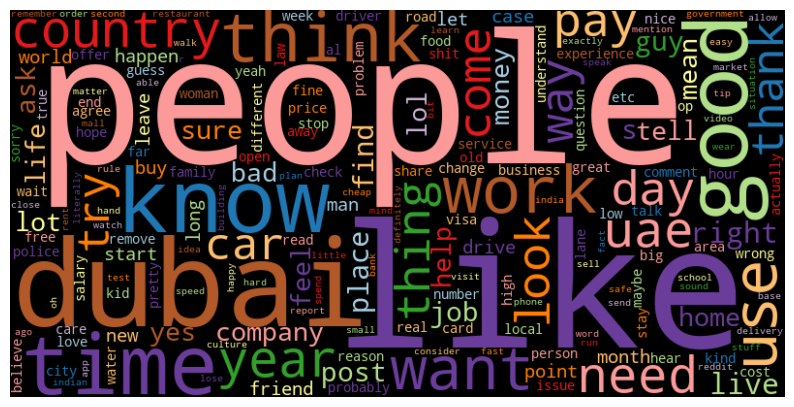

In [104]:
#wordcloud of most frequent words


# Generate the word cloud
wordcloud = WordCloud(
                width=800, 
                height=400,  
                background_color="black", 
                colormap="Paired").generate_from_frequencies(#dictionary of word and their frequency of occurrence
                                                        FreqDist(
                                                            [word for text in data['clean_text'] for word in text.split()])
                        )

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [108]:
#load custom_stop_words list
with open('custom_stop_words.txt', 'r') as file:
    custom_sw = [line.strip() for line in file]
print (f'There are {len(custom_sw)} in the custom stop words list')
print ('\n')
print (random.sample(custom_sw, 5))

There are 32792 in the custom stop words list


['summit', 'qas', 'abandonment', 'wahala', 'visita']


In [110]:
#remove custom words

data['clean_text'] = data['clean_text'].apply(lambda text: ' '.join([word for word in text.split() if word not in custom_sw]))

data.sample(n=5)                                    

,text_type,ID,date_created,year,long_text,clean_text
84879,comment,ghuxmy6,2021-01-03 00:23:15,2021,"Yeah, we all hear very good news about that. I...",stop target weight
104977,comment,g1g4plp,2020-08-14 19:01:31,2020,What on earth are you on about? Was there a wa...,earth war
46286,comment,fbed42z,2019-12-19 23:21:24,2019,"If ur talking about Homebox, I second this, th...",homebox crappy furniture customer service desi...
101596,comment,i8frlnx,2022-05-13 15:15:21,2022,"Rest In Peace your Highness, your kindness wil...",rest peace highness kindness
67503,comment,h71tmwv,2021-07-30 09:23:04,2021,Really? Which school bruh?\n\nTbh my school en...,school bruh school ensure final payment


In [117]:
#check top words after removal of common stop words

#list of all words in the dataframe
all_words = [word for text in data['clean_text'] for word in text.split()]

#frequency of word occurrence
fdist = FreqDist(all_words)

#common_words = fdist.most_common(10)

#table of common words
common_words_table = PrettyTable(['word', 'count'])
for word, count in fdist.most_common(10):
    common_words_table.add_row([word, count])

print (common_words_table)

+---------+-------+
|   word  | count |
+---------+-------+
|  drive  |  2951 |
|   buy   |  2721 |
|   fine  |  2272 |
|   food  |  2269 |
|  price  |  2232 |
|   stop  |  2133 |
|  family |  2130 |
|  police |  2088 |
|   lane  |  2075 |
| service |  1891 |
+---------+-------+


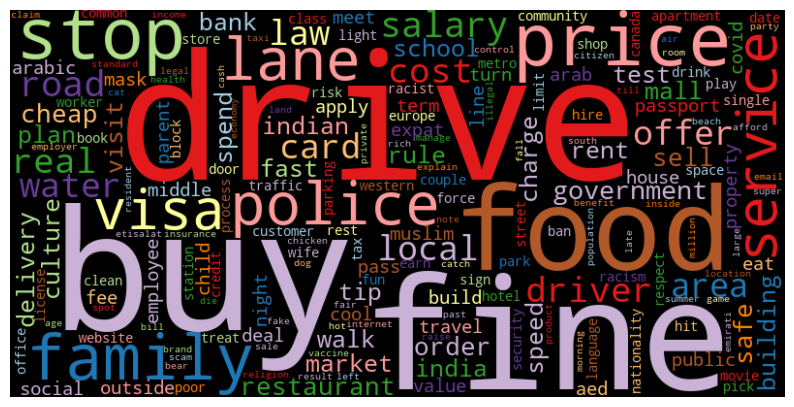

In [118]:
#wordcloud of most frequent words


# Generate the word cloud
wordcloud = WordCloud(
                width=800, 
                height=400,  
                background_color="black", 
                colormap="Paired").generate_from_frequencies(#dictionary of word and their frequency of occurrence
                                                        FreqDist(
                                                            [word for text in data['clean_text'] for word in text.split()])
                        )

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## **Remove Extra Whitespaces**

In [119]:
data['clean_text'] = data['clean_text'].str.strip().str.replace('\s+', ' ', regex = True)

sample_rows = [5786,18460, 103391, 129297]

#redo word_count
#data['word_count'] = data['clean_text'].apply (lambda text: len(text.split()))

data.loc[sample_rows]#.sort_values(by='word_count', ascending = False)

,text_type,ID,date_created,year,long_text,clean_text
5786,comment,ji7mk4q,2023-04-29 22:19:10,2023,This really isnt news.\n\nThe UAE has always b...,indian entrepreneur stat indian millionaire india
18460,comment,j5nec03,2023-01-24 09:49:19,2023,Creep,creep
103391,comment,d57mm8v,2016-07-11 11:42:56,2016,Intellectuals meet with other intellectuals.,intellectual meet intellectual
129297,submission,ks5wh3,2021-01-07 08:46:06,2021,Recommendations for South Indian food tiffin s...,south indian food service lunch service south ...


## **Word Tokenization - NLTK**

In [120]:
data['tokens'] = data['clean_text'].apply(lambda text: word_tokenize(text))

data.iloc[rows_to_check]

,text_type,ID,date_created,year,long_text,clean_text,tokens
125797,submission,ifquow,2020-08-24 19:13:26,2020,GUYS WE MADE IT!!! YAY,yay,[yay]
126266,submission,gzl2ec,2020-06-09 15:11:27,2020,"PSA: Immigration to Canada, Australia, NZ Hell...",psa immigration canada australia inquiry immig...,"[psa, immigration, canada, australia, inquiry,..."
127896,submission,147gsfl,2023-06-12 10:22:19,2023,How to reach people who are asking for money/g...,grocery normally society requirement donation ...,"[grocery, normally, society, requirement, dona..."
128038,submission,12pqx6m,2023-04-17 22:00:27,2023,How do you plan to spend your Eid holiday? Any...,plan spend eid holiday fun activity trip line ...,"[plan, spend, eid, holiday, fun, activity, tri..."
128385,submission,vtelex,2022-07-07 13:32:10,2022,"Hi everyone, I'm currently looking for jobs te...",temporary permanent visa drive license thankful,"[temporary, permanent, visa, drive, license, t..."
...,...,...,...,...,...,...,...
129946,submission,14djkvs,2023-06-19 20:39:46,2023,Help‼️Uni qualification equivalency letter for...,uni qualification letter master application co...,"[uni, qualification, letter, master, applicati..."
130004,submission,14d2uk9,2023-06-19 07:06:28,2023,PSA: Villas are at high risk of fire during th...,psa villas risk fire summer community fire vil...,"[psa, villas, risk, fire, summer, community, f..."
130006,submission,14d0c29,2023-06-19 05:00:13,2023,"Daily Random Discussion Thread Hello,\n\nThis ...",active monthly june monthly classified june mo...,"[active, monthly, june, monthly, classified, j..."
130037,submission,14cieby,2023-06-18 15:43:08,2023,Need help with applying for residency - confus...,apply residency confuse order land virtual ent...,"[apply, residency, confuse, order, land, virtu..."


## **Insert Word Count**

In [122]:
data['word_count'] = data['tokens'].apply (lambda tokens_list: len(tokens_list))

data.sort_values(by='word_count', ascending = False)

,text_type,ID,date_created,year,long_text,clean_text,tokens,word_count
126266,submission,gzl2ec,2020-06-09 15:11:27,2020,"PSA: Immigration to Canada, Australia, NZ Hell...",psa immigration canada australia inquiry immig...,"[psa, immigration, canada, australia, inquiry,...",755
126553,submission,jh5hjq,2020-10-24 12:29:05,2020,List of discounts and working promo codes in D...,discount promo code discount promo code tip di...,"[discount, promo, code, discount, promo, code,...",634
5785,comment,ji1smg1,2023-04-28 17:10:21,2023,"FULLTEXT\nApr 27, 2023\n\nStand in the middle ...",apr middle meena bazaar mile arabian sea mumba...,"[apr, middle, meena, bazaar, mile, arabian, se...",414
18459,comment,jj2t0ih,2023-05-06 15:40:03,2023,"FULL TEXT:\n\nBy Archana Narayanan, Abeer Abu ...",text omar bloomberg gamble industry bet united...,"[text, omar, bloomberg, gamble, industry, bet,...",369
30108,comment,hb5qzzy,2021-09-01 10:58:17,2021,How to get a visit visa to the UAE?\n\ngulfnew...,visit visa gulfnews com purpose image credit s...,"[visit, visa, gulfnews, com, purpose, image, c...",369
...,...,...,...,...,...,...,...,...
18062,comment,ivemrl4,2022-11-07 16:27:12,2022,took me exactly 38 seconds,,[],0
56713,comment,ik67bpw,2022-08-14 00:39:54,2022,$ 80k per year,,[],0
56719,comment,ik7usrk,2022-08-14 08:51:22,2022,Yeah I agree!,,[],0
56723,comment,j3vpqie,2023-01-11 15:44:35,2023,I’ve never had chance to say this before but h...,,[],0


## **Remove Short Text Entries**

In [131]:
#select only rows with more than 1 word
corpus = data[data['word_count'] > 2]

corpus.shape

(66754, 8)

## **Remove Subset for manual labelling**

In [137]:
#load list of sample_subset indices

#sampling done previously by randomly selecting entries from each year

with open('sample_subset_index.txt', 'r') as file:
    subset_index = [line.strip() for line in file]

subset_index[:5]

['hbbcq6z', 'hjjhl9r', 'h7ntxws', 'h02sz1n', 'hnuysoa']

In [139]:
#remove randomly sampled subset


subset_index = corpus[corpus['ID'].isin(subset_index)].index.to_list()

#remove sample subset from corpus

training_data = corpus.drop(subset_index, axis = 0)
training_data.sort_values(by='word_count', ascending = False)

training_data

,text_type,ID,date_created,year,long_text,clean_text,tokens,word_count
2,comment,gtfou07,2021-04-05 13:13:23,2021,I am single and I have not traveled to any cun...,single travel past,"[single, travel, past]",3
3,comment,gtfrgpe,2021-04-05 13:56:09,2021,What happens when you shop at dragon mart...,shop dragon mart,"[shop, dragon, mart]",3
5,comment,gthiiwi,2021-04-05 23:18:56,2021,"That’s just absolutely hilarious, is this in t...",hilarious spring souk,"[hilarious, spring, souk]",3
13,comment,gtgfl4c,2021-04-05 18:21:42,2021,Is reel cinema and roxy part of emaar?,reel cinema roxy emaar,"[reel, cinema, roxy, emaar]",4
18,comment,gth5wdv,2021-04-05 21:42:41,2021,An innocent redditor here...can someone pls ex...,innocent pls explain everyday,"[innocent, pls, explain, everyday]",4
...,...,...,...,...,...,...,...,...
130046,submission,14f49ta,2023-06-21 14:45:45,2023,Legal advice needed. Would highly appreciate i...,legal highly legal highly private involved par...,"[legal, highly, legal, highly, private, involv...",10
130047,submission,14f46ji,2023-06-21 14:40:54,2023,"Best beauty saloons in Dubai? Hello fellas, I ...",beauty saloon fella wife real saloon beauty sa...,"[beauty, saloon, fella, wife, real, saloon, be...",17
130049,submission,14f4ri3,2023-06-21 15:10:25,2023,Scam ? Healthy.line My sister has a CBD debit ...,scam healthy line sister cbd debit card april ...,"[scam, healthy, line, sister, cbd, debit, card...",35
130050,submission,14f4k3r,2023-06-21 15:00:34,2023,Thoughts on Expo City properties? Anyone else ...,expo property expo sale pleasant price locate ...,"[expo, property, expo, sale, pleasant, price, ...",9


In [142]:
#save corpus 
filename = '../Data/training_data.csv'

def export_csv():
    '''
    export pre-processed data to CSV
    '''
    training_data.to_csv(filename, index_label = 'index', quoting = csv.QUOTE_ALL, header = True)

export_csv()

print ('file saved')

file saved


## **Translate Emoticons**

In [ ]:
"""def find_emoji(text):
    try:
        emoticon_details = next(emoji.analyze(text, join_emoji=True))
        emoticon = emoticon_details.chars
        #translated_emoji = emoji.demojize(emoticon.chars)
    except StopIteration:
        emoticon = ''  # Handle the case when no emoji is found
    return  emoticon

data['emoticons'] = data['long_text'].apply (lambda text: find_emoji(text) )
data['translated_emojis'] = data['emoticons'].apply(lambda text: emoji.demojize(text))

emoji_index = [3709,33734,129114,100878]

data.loc[emoji_index]"""